# Proyecto Redes Neuronales: Perceptrón Multicapa con Embeddings (PyTorch)

**Curso:** Redes Neuronales 2025-II  
**Objetivo:** Entrenar y evaluar un modelo MLP con embeddings usando PyTorch (Entrega 1 - refactorización)  
**Autor:** Herney Eduardo Quintero Trochez  
**Fecha:** 2025  
**Universidad:** Universidad Del Valle  

## 0. Configuración de Parámetros Globales

In [1]:
# ===== CONFIGURACIÓN DE PARÁMETROS GLOBALES =====

# Configuración general del experimento
EXPERIMENT_NAME = "MLP_PyTorch_Embedding"
MODEL_TYPE = "MLP_Embedding_Torch"
RANDOM_SEED = 42
PROJECT_PART = "project_part_1"

# Directorios de trabajo
DATA_DIR = "data"
MODEL_DIR = f"models/{PROJECT_PART}"
OUTPUT_DIR = f"output/{PROJECT_PART}"

# Configuración del dataset
TEXT_COLUMN = "review_body"
TITLE_COLUMN = "review_title"
TARGET_COLUMN = "stars"
LANGUAGE_COLUMN = "language"
FILTER_LANGUAGE = "en"  # None para todos
USE_TITLE_AND_BODY = True

# Parámetros de tokenización y vocabulario
MAX_VOCAB_SIZE = 80000
MAX_LENGTH = 300
OOV_TOKEN = "<OOV>"
PAD_TOKEN = "<PAD>"

# Arquitectura del modelo
EMBEDDING_DIM = 300
HIDDEN_LAYERS = [256, 128, 64]
DROPOUT_RATE = 0.5  

# Parámetros de entrenamiento
EPOCHS = 50
BATCH_SIZE = 512
LEARNING_RATE = 0.0005  
PATIENCE = 15  
WEIGHT_DECAY = 0.0001  

print(f"=== Configuración: {EXPERIMENT_NAME} ===")
print(f"Framework: PyTorch")
print(f"Proyecto: {PROJECT_PART}")
print(f"Idioma: {FILTER_LANGUAGE if FILTER_LANGUAGE else 'Multiidioma'}")
print(f"Embedding: {EMBEDDING_DIM}d")
print(f"Max Length: {MAX_LENGTH}")
print(f"Arquitectura: {HIDDEN_LAYERS}")
print(f"Dropout: {DROPOUT_RATE} (aumentado para regularización)")
print(f"Learning Rate: {LEARNING_RATE} (reducido para estabilidad)")
print(f"Weight Decay: {WEIGHT_DECAY} (L2 regularization)")
print(f"Patience: {PATIENCE}")
print("="*60)

=== Configuración: MLP_PyTorch_Embedding ===
Framework: PyTorch
Proyecto: project_part_1
Idioma: en
Embedding: 300d
Max Length: 300
Arquitectura: [256, 128, 64]
Dropout: 0.5 (aumentado para regularización)
Learning Rate: 0.0005 (reducido para estabilidad)
Weight Decay: 0.0001 (L2 regularization)
Patience: 15


## 1. Importación de Librerías

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from datetime import datetime
from sklearn.metrics import classification_report

# Importar helpers directamente desde sus módulos
from helpers.data_loader_torch import DataLoaderTorch
from helpers.model_trainer_torch import ModelTrainerTorch
from helpers.results_manager import ResultsManager
from helpers.visualizer import Visualizer
from helpers.models import MLPWithEmbedding
from helpers.utils import (
    setup_experiment_environment_torch,
    save_model_components_torch,
    evaluate_model_torch
)

# Configurar ambiente
gpu_info = setup_experiment_environment_torch(RANDOM_SEED)
print(f"GPU disponible: {gpu_info['gpu_available']}")
if gpu_info['gpu_available']:
    print(f"GPU: {gpu_info['gpu_names']}")
    print(f"CUDA: {gpu_info['cuda_version']}")

GPU configurada: 1 GPU(s) disponibles
Usando: NVIDIA GeForce RTX 5070
GPU disponible: True
GPU: ['NVIDIA GeForce RTX 5070']
CUDA: 13.0


## 2. Carga y Preprocesamiento de Datos

In [3]:
# Cargar datos
data_loader = DataLoaderTorch(data_dir=DATA_DIR)
train_df, val_df, test_df = data_loader.load_all_data()

print(f"\nDatos originales:")
print(f"Train: {len(train_df):,}, Val: {len(val_df):,}, Test: {len(test_df):,}")

# Filtrar por idioma si se especifica
if FILTER_LANGUAGE and LANGUAGE_COLUMN in train_df.columns:
    print(f"\nFiltrando por idioma: {FILTER_LANGUAGE}")
    train_df = train_df[train_df[LANGUAGE_COLUMN] == FILTER_LANGUAGE].copy()
    val_df = val_df[val_df[LANGUAGE_COLUMN] == FILTER_LANGUAGE].copy()
    test_df = test_df[test_df[LANGUAGE_COLUMN] == FILTER_LANGUAGE].copy()
    print(f"Filtrados: Train: {len(train_df):,}, Val: {len(val_df):,}, Test: {len(test_df):,}")

# Distribución de clases
print(f"\nDistribución de clases:")
class_distribution = train_df[TARGET_COLUMN].value_counts().sort_index()
for stars, count in class_distribution.items():
    print(f"  {stars} estrellas: {count:,} ({count/len(train_df)*100:.1f}%)")

Datos cargados exitosamente: train.csv
Datos cargados exitosamente: validation.csv
Datos cargados exitosamente: test.csv

Datos originales:
Train: 1,200,000, Val: 30,000, Test: 30,000

Filtrando por idioma: en
Filtrados: Train: 200,000, Val: 5,000, Test: 5,000

Distribución de clases:
  1 estrellas: 40,000 (20.0%)
  2 estrellas: 40,000 (20.0%)
  3 estrellas: 40,000 (20.0%)
  4 estrellas: 40,000 (20.0%)
  5 estrellas: 40,000 (20.0%)


## 3. Preprocesamiento con Embeddings (PyTorch)

In [4]:
# Preprocesar datos con embeddings
print("\nPreprocesando con PyTorch (Embeddings)...")
processed = data_loader.preprocess_text_data_embedding(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    text_column=TEXT_COLUMN,
    title_column=TITLE_COLUMN if USE_TITLE_AND_BODY else None,
    target_column=TARGET_COLUMN,
    max_words=MAX_VOCAB_SIZE,
    max_length=MAX_LENGTH,
    use_title_and_body=USE_TITLE_AND_BODY,
    batch_size=BATCH_SIZE
)

# Extraer info
train_loader = processed['train_loader']
val_loader = processed['val_loader']
test_loader = processed['test_loader']
num_classes = processed['num_classes']
vocab_size = processed['vocab_size']

print(f"\nVocabulario: {vocab_size}")
print(f"Clases: {num_classes}")
print(f"Max Length: {MAX_LENGTH}")

class_names = [str(i) for i in data_loader.label_encoder.classes_]


Preprocesando con PyTorch (Embeddings)...
Preprocesando datos de texto...
Ajustando tokenizer solo con datos de entrenamiento (evitando data leakage)...
Tamaño del vocabulario real: 48282
Vocab size usado (limitado): 48283
Número de clases: 5
Longitud de secuencia: 300
Texto combinado: Sí (título + cuerpo)
Muestras de entrenamiento: 200000
Muestras de validación: 5000
Muestras de prueba: 5000

Vocabulario: 48283
Clases: 5
Max Length: 300


## 4. Construcción del Modelo PyTorch con Embeddings

In [5]:
# Crear modelo
print("\nCreando modelo PyTorch con Embeddings...")
model = MLPWithEmbedding(
    vocab_size=vocab_size,  
    embedding_dim=EMBEDDING_DIM,
    hidden_layers=HIDDEN_LAYERS,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    padding_idx=0,
    use_masked_pooling=False 
)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Parámetros totales: {total_params:,}")
print(f"Parámetros entrenables: {trainable_params:,}")
print(f"Arquitectura: Embedding({vocab_size} -> {EMBEDDING_DIM}) -> {HIDDEN_LAYERS}")
print(f"Masked pooling: False (igual que TF sin mask_zero)")

# Verificar inicialización de embeddings
emb_min = model.embedding.weight.min().item()
emb_max = model.embedding.weight.max().item()
print(f"Embedding weights range: [{emb_min:.4f}, {emb_max:.4f}] (esperado: [-0.05, 0.05])")



Creando modelo PyTorch con Embeddings...
Parámetros totales: 14,680,814
Parámetros entrenables: 14,680,814
Arquitectura: Embedding(48283 -> 300) -> [256, 128, 64]
Masked pooling: False (igual que TF sin mask_zero)
Embedding weights range: [-0.0500, 0.0500] (esperado: [-0.05, 0.05])


## 5. Configuración de Entrenamiento

In [6]:
# Definir criterio y optimizador
criterion = nn.CrossEntropyLoss()
# AÑADIDO: weight_decay para regularización L2 (igual que TensorFlow)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=PATIENCE//3
)

print("\nConfiguración:")
print(f"Optimizador: Adam (lr={LEARNING_RATE}, weight_decay={WEIGHT_DECAY})")
print(f"Loss: CrossEntropyLoss")
print(f"Scheduler: ReduceLROnPlateau (factor=0.5, patience={PATIENCE//3})")
print(f"Regularización: Dropout={DROPOUT_RATE} + L2={WEIGHT_DECAY}")


Configuración:
Optimizador: Adam (lr=0.0005, weight_decay=0.0001)
Loss: CrossEntropyLoss
Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)
Regularización: Dropout=0.5 + L2=0.0001


## 6. Entrenamiento

In [7]:
# Entrenar
trainer = ModelTrainerTorch(model_dir=MODEL_DIR)

print("\nIniciando entrenamiento...")
training_results = trainer.train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=EPOCHS,
    patience=PATIENCE,
    model_name=f"{MODEL_TYPE}_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
    scheduler=scheduler
)

print(f"\nEntrenamiento completado:")
print(f"Épocas: {training_results['epochs_trained']}")
print(f"Tiempo: {training_results['training_time']:.1f}s")
print(f"Mejor Val Acc: {training_results['best_val_accuracy']:.4f}")

# Guardar componentes
model_name = os.path.basename(training_results['model_path']).replace('.pth', '')
save_model_components_torch(
    model_name=model_name,
    model=model,
    tokenizer=data_loader.tokenizer,  # CORRECCIÓN: Usar tokenizer en lugar de vocab
    label_encoder=data_loader.label_encoder,
    max_length=MAX_LENGTH,
    model_dir=MODEL_DIR
)

Usando dispositivo: cuda

Iniciando entrenamiento...

Entrenando MLP_Embedding_Torch_20251130_135607...
Parámetros totales: 14,680,814
Parámetros entrenables: 14,680,814


Epoch 1/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 313.95it/s, loss=0.7316, acc=51.58%]



Epoch 1/50:
  Train Loss: 1.3313, Train Acc: 0.3816, Train F1-Macro: 0.3683
  Val Loss: 1.0790, Val Acc: 0.5158, Val F1-Macro: 0.5038
  Learning Rate: 0.000500
  ✓ Mejor modelo guardado (Val F1-Macro: 0.5038)


Epoch 2/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 335.79it/s, loss=0.6781, acc=57.06%]



Epoch 2/50:
  Train Loss: 1.0717, Train Acc: 0.5412, Train F1-Macro: 0.5347
  Val Loss: 1.0074, Val Acc: 0.5706, Val F1-Macro: 0.5689
  Learning Rate: 0.000500
  ✓ Mejor modelo guardado (Val F1-Macro: 0.5689)


Epoch 3/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 332.75it/s, loss=0.6479, acc=57.72%]



Epoch 3/50:
  Train Loss: 1.0229, Train Acc: 0.5699, Train F1-Macro: 0.5650
  Val Loss: 0.9885, Val Acc: 0.5772, Val F1-Macro: 0.5720
  Learning Rate: 0.000500
  ✓ Mejor modelo guardado (Val F1-Macro: 0.5720)


Epoch 4/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 349.97it/s, loss=0.6510, acc=58.20%]



Epoch 4/50:
  Train Loss: 1.0024, Train Acc: 0.5799, Train F1-Macro: 0.5761
  Val Loss: 0.9850, Val Acc: 0.5820, Val F1-Macro: 0.5809
  Learning Rate: 0.000500
  ✓ Mejor modelo guardado (Val F1-Macro: 0.5809)


Epoch 5/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 350.84it/s, loss=0.6803, acc=58.56%]



Epoch 5/50:
  Train Loss: 0.9902, Train Acc: 0.5847, Train F1-Macro: 0.5811
  Val Loss: 0.9774, Val Acc: 0.5856, Val F1-Macro: 0.5823
  Learning Rate: 0.000500
  ✓ Mejor modelo guardado (Val F1-Macro: 0.5823)


Epoch 6/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 331.43it/s, loss=0.6348, acc=58.20%]



Epoch 6/50:
  Train Loss: 0.9766, Train Acc: 0.5911, Train F1-Macro: 0.5879
  Val Loss: 0.9733, Val Acc: 0.5820, Val F1-Macro: 0.5773
  Learning Rate: 0.000500
  Épocas sin mejora: 1/15


Epoch 7/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 350.23it/s, loss=0.6413, acc=58.78%]



Epoch 7/50:
  Train Loss: 0.9669, Train Acc: 0.5953, Train F1-Macro: 0.5922
  Val Loss: 0.9671, Val Acc: 0.5878, Val F1-Macro: 0.5817
  Learning Rate: 0.000500
  Épocas sin mejora: 2/15


Epoch 8/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 329.05it/s, loss=0.6099, acc=58.56%]



Epoch 8/50:
  Train Loss: 0.9602, Train Acc: 0.6000, Train F1-Macro: 0.5970
  Val Loss: 0.9679, Val Acc: 0.5856, Val F1-Macro: 0.5805
  Learning Rate: 0.000500
  Épocas sin mejora: 3/15


Epoch 9/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 273.89it/s, loss=0.5793, acc=59.40%]



Epoch 9/50:
  Train Loss: 0.9519, Train Acc: 0.6019, Train F1-Macro: 0.5991
  Val Loss: 0.9659, Val Acc: 0.5940, Val F1-Macro: 0.5863
  Learning Rate: 0.000500
  ✓ Mejor modelo guardado (Val F1-Macro: 0.5863)


Epoch 10/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 332.13it/s, loss=0.6374, acc=58.52%]



Epoch 10/50:
  Train Loss: 0.9451, Train Acc: 0.6043, Train F1-Macro: 0.6015
  Val Loss: 0.9716, Val Acc: 0.5852, Val F1-Macro: 0.5789
  Learning Rate: 0.000500
  Épocas sin mejora: 1/15


Epoch 11/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 333.50it/s, loss=0.5845, acc=58.82%]



Epoch 11/50:
  Train Loss: 0.9380, Train Acc: 0.6071, Train F1-Macro: 0.6043
  Val Loss: 0.9651, Val Acc: 0.5882, Val F1-Macro: 0.5825
  Learning Rate: 0.000500
  Épocas sin mejora: 2/15


Epoch 12/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 331.65it/s, loss=0.6040, acc=58.78%]



Epoch 12/50:
  Train Loss: 0.9329, Train Acc: 0.6101, Train F1-Macro: 0.6074
  Val Loss: 0.9691, Val Acc: 0.5878, Val F1-Macro: 0.5820
  Learning Rate: 0.000500
  Épocas sin mejora: 3/15


Epoch 13/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 338.05it/s, loss=0.6428, acc=59.00%]



Epoch 13/50:
  Train Loss: 0.9258, Train Acc: 0.6134, Train F1-Macro: 0.6105
  Val Loss: 0.9657, Val Acc: 0.5900, Val F1-Macro: 0.5863
  Learning Rate: 0.000500
  Épocas sin mejora: 4/15


Epoch 14/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 340.48it/s, loss=0.6510, acc=58.82%]



Epoch 14/50:
  Train Loss: 0.9198, Train Acc: 0.6145, Train F1-Macro: 0.6119
  Val Loss: 0.9664, Val Acc: 0.5882, Val F1-Macro: 0.5827
  Learning Rate: 0.000500
  Épocas sin mejora: 5/15


Epoch 15/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 330.41it/s, loss=0.6585, acc=58.80%]



Epoch 15/50:
  Train Loss: 0.9134, Train Acc: 0.6174, Train F1-Macro: 0.6148
  Val Loss: 0.9599, Val Acc: 0.5880, Val F1-Macro: 0.5848
  Learning Rate: 0.000500
  Épocas sin mejora: 6/15


Epoch 16/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 345.08it/s, loss=0.6650, acc=59.22%]



Epoch 16/50:
  Train Loss: 0.9070, Train Acc: 0.6193, Train F1-Macro: 0.6167
  Val Loss: 0.9632, Val Acc: 0.5922, Val F1-Macro: 0.5883
  Learning Rate: 0.000500
  ✓ Mejor modelo guardado (Val F1-Macro: 0.5883)


Epoch 17/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 345.87it/s, loss=0.5867, acc=59.10%]



Epoch 17/50:
  Train Loss: 0.9026, Train Acc: 0.6209, Train F1-Macro: 0.6184
  Val Loss: 0.9597, Val Acc: 0.5910, Val F1-Macro: 0.5867
  Learning Rate: 0.000500
  Épocas sin mejora: 1/15


Epoch 18/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 319.63it/s, loss=0.6611, acc=58.68%]



Epoch 18/50:
  Train Loss: 0.8970, Train Acc: 0.6236, Train F1-Macro: 0.6212
  Val Loss: 0.9757, Val Acc: 0.5868, Val F1-Macro: 0.5828
  Learning Rate: 0.000500
  Épocas sin mejora: 2/15


Epoch 19/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 323.36it/s, loss=0.7037, acc=58.82%]



Epoch 19/50:
  Train Loss: 0.8923, Train Acc: 0.6260, Train F1-Macro: 0.6234
  Val Loss: 0.9708, Val Acc: 0.5882, Val F1-Macro: 0.5844
  Learning Rate: 0.000500
  Épocas sin mejora: 3/15


Epoch 20/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 330.49it/s, loss=0.5871, acc=58.64%]



Epoch 20/50:
  Train Loss: 0.8877, Train Acc: 0.6280, Train F1-Macro: 0.6255
  Val Loss: 0.9786, Val Acc: 0.5864, Val F1-Macro: 0.5753
  Learning Rate: 0.000500
  Épocas sin mejora: 4/15


Epoch 21/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 336.99it/s, loss=0.5978, acc=58.64%]



Epoch 21/50:
  Train Loss: 0.8816, Train Acc: 0.6307, Train F1-Macro: 0.6281
  Val Loss: 0.9755, Val Acc: 0.5864, Val F1-Macro: 0.5795
  Learning Rate: 0.000500
  Épocas sin mejora: 5/15


Epoch 22/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 335.90it/s, loss=0.6357, acc=58.72%]



Epoch 22/50:
  Train Loss: 0.8760, Train Acc: 0.6321, Train F1-Macro: 0.6297
  Val Loss: 0.9737, Val Acc: 0.5872, Val F1-Macro: 0.5823
  Learning Rate: 0.000500
  Épocas sin mejora: 6/15


Epoch 23/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 320.24it/s, loss=0.6656, acc=58.70%]



Epoch 23/50:
  Train Loss: 0.8697, Train Acc: 0.6360, Train F1-Macro: 0.6335
  Val Loss: 0.9778, Val Acc: 0.5870, Val F1-Macro: 0.5846
  Learning Rate: 0.000250
  Épocas sin mejora: 7/15


Epoch 24/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 342.34it/s, loss=0.6293, acc=58.74%]



Epoch 24/50:
  Train Loss: 0.8424, Train Acc: 0.6492, Train F1-Macro: 0.6469
  Val Loss: 0.9864, Val Acc: 0.5874, Val F1-Macro: 0.5819
  Learning Rate: 0.000250
  Épocas sin mejora: 8/15


Epoch 25/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 344.48it/s, loss=0.6535, acc=58.26%]



Epoch 25/50:
  Train Loss: 0.8318, Train Acc: 0.6541, Train F1-Macro: 0.6520
  Val Loss: 0.9983, Val Acc: 0.5826, Val F1-Macro: 0.5768
  Learning Rate: 0.000250
  Épocas sin mejora: 9/15


Epoch 26/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 324.99it/s, loss=0.6692, acc=58.68%]



Epoch 26/50:
  Train Loss: 0.8232, Train Acc: 0.6588, Train F1-Macro: 0.6570
  Val Loss: 0.9986, Val Acc: 0.5868, Val F1-Macro: 0.5829
  Learning Rate: 0.000250
  Épocas sin mejora: 10/15


Epoch 27/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 259.49it/s, loss=0.7390, acc=58.58%]



Epoch 27/50:
  Train Loss: 0.8170, Train Acc: 0.6623, Train F1-Macro: 0.6605
  Val Loss: 1.0031, Val Acc: 0.5858, Val F1-Macro: 0.5838
  Learning Rate: 0.000250
  Épocas sin mejora: 11/15


Epoch 28/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 346.65it/s, loss=0.6534, acc=58.46%]



Epoch 28/50:
  Train Loss: 0.8115, Train Acc: 0.6634, Train F1-Macro: 0.6617
  Val Loss: 1.0024, Val Acc: 0.5846, Val F1-Macro: 0.5790
  Learning Rate: 0.000250
  Épocas sin mejora: 12/15


Epoch 29/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 348.30it/s, loss=0.6700, acc=58.18%]



Epoch 29/50:
  Train Loss: 0.8044, Train Acc: 0.6679, Train F1-Macro: 0.6661
  Val Loss: 1.0133, Val Acc: 0.5818, Val F1-Macro: 0.5781
  Learning Rate: 0.000125
  Épocas sin mejora: 13/15


Epoch 30/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 342.16it/s, loss=0.6701, acc=58.56%]



Epoch 30/50:
  Train Loss: 0.7811, Train Acc: 0.6810, Train F1-Macro: 0.6795
  Val Loss: 1.0211, Val Acc: 0.5856, Val F1-Macro: 0.5822
  Learning Rate: 0.000125
  Épocas sin mejora: 14/15


Epoch 31/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 352.32it/s, loss=0.6715, acc=58.28%]



Epoch 31/50:
  Train Loss: 0.7721, Train Acc: 0.6867, Train F1-Macro: 0.6854
  Val Loss: 1.0364, Val Acc: 0.5828, Val F1-Macro: 0.5800
  Learning Rate: 0.000125
  Épocas sin mejora: 15/15

Early stopping en época 31

Mejor modelo restaurado
Modelo guardado en: models/project_part_1/MLP_Embedding_Torch_20251130_135607.pth

Entrenamiento completado:
Épocas: 31
Tiempo: 91.9s
Mejor Val Acc: 0.5922
Modelo guardado: models/project_part_1/MLP_Embedding_Torch_20251130_135607.pth
  - Configuración guardada: {'vocab_size': 48283, 'embedding_dim': 300, 'hidden_layers': [256, 128, 64], 'num_classes': 5, 'use_masked_pooling': False, 'max_length': 300}
Tokenizer guardado: models/project_part_1/MLP_Embedding_Torch_20251130_135607_tokenizer.pkl
Label encoder guardado: models/project_part_1/MLP_Embedding_Torch_20251130_135607_label_encoder.pkl
Componentes guardados en models/project_part_1/


## 7. Visualización

Gráfico de historial de entrenamiento guardado en: output/project_part_1/MLP_Embedding_Torch_training.png


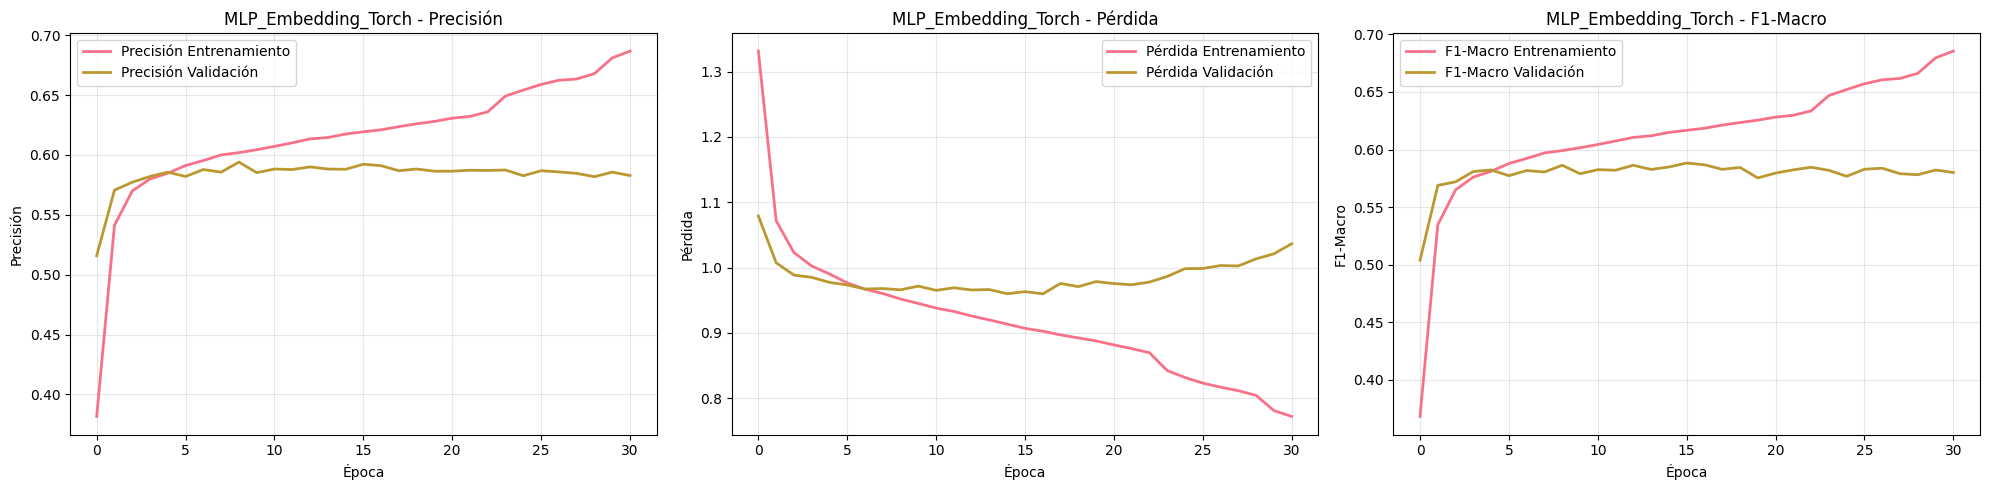

In [8]:
# Visualizar historial
Visualizer.plot_training_history(
    history=training_results['history'],
    model_name=MODEL_TYPE,
    save_path=os.path.join(OUTPUT_DIR, f"{MODEL_TYPE}_training.png"),
    framework="pytorch"
)

## 8. Evaluación

In [9]:
# Evaluar
eval_results = evaluate_model_torch(
    model=model,
    test_loader=test_loader,
    criterion=criterion,
    device=trainer.device,
    class_names=class_names
)

test_accuracy = eval_results['test_accuracy']
test_loss = eval_results['test_loss']
y_true = eval_results['y_true']
y_pred = eval_results['y_pred']

classification_rep = classification_report(y_true, y_pred, 
                                          target_names=class_names, 
                                          output_dict=True)

print(f"\nResultados:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Loss: {test_loss:.4f}")
print(f"F1 (macro): {classification_rep['macro avg']['f1-score']:.4f}")

Evaluando modelo en datos de prueba...
Precisión de Prueba: 0.5886
Pérdida de Prueba: 1.0281

Reporte de Clasificación:
              precision    recall  f1-score   support

           1       0.66      0.69      0.68      1000
           2       0.50      0.47      0.49      1000
           3       0.48      0.48      0.48      1000
           4       0.58      0.53      0.55      1000
           5       0.71      0.78      0.74      1000

    accuracy                           0.59      5000
   macro avg       0.58      0.59      0.59      5000
weighted avg       0.58      0.59      0.59      5000


Resultados:
Accuracy: 0.5886
Loss: 1.0281
F1 (macro): 0.5859


## 9. Matriz de Confusión

Matriz de confusión guardada en: output/project_part_1/MLP_Embedding_Torch_confusion.png


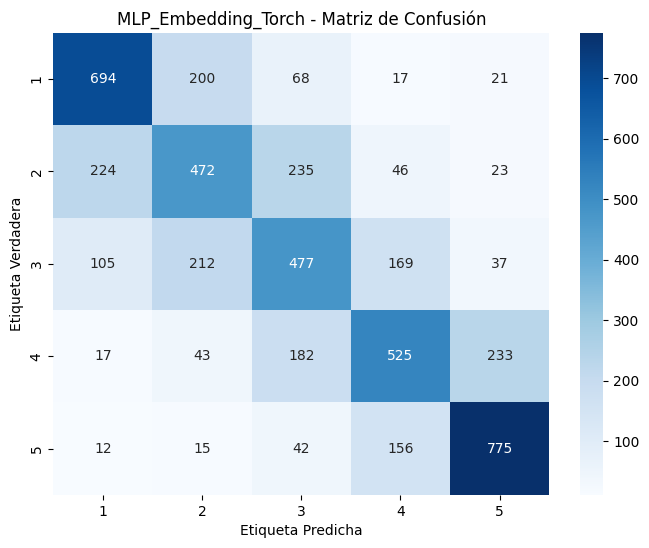

In [10]:
# Matriz de confusión
Visualizer.plot_confusion_matrix(
    y_true=y_true,
    y_pred=y_pred,
    class_names=class_names,
    model_name=MODEL_TYPE,
    save_path=os.path.join(OUTPUT_DIR, f"{MODEL_TYPE}_confusion.png")
)

## 10. Guardar Experimento

In [11]:
# Preparar datos del experimento
experiment_data = {
    'experiment_name': EXPERIMENT_NAME,
    'configuration': {
        'model_type': MODEL_TYPE,
        'framework': 'pytorch',
        'language_filter': FILTER_LANGUAGE,
        'max_vocab_size': MAX_VOCAB_SIZE,
        'max_length': MAX_LENGTH,
        'embedding_dim': EMBEDDING_DIM,
        'hidden_layers': HIDDEN_LAYERS,
        'dropout_rate': DROPOUT_RATE,
        'epochs': EPOCHS,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'total_parameters': total_params,
        'trainable_parameters': trainable_params,
        'gpu_used': gpu_info['gpu_available']
    },
    'dataset_info': {
        'train_samples': len(train_df),
        'val_samples': len(val_df),
        'test_samples': len(test_df),
        'num_classes': num_classes,
        'vocab_size': vocab_size,
        'class_distribution': class_distribution.to_dict()
    },
    'training_results': training_results,
    'evaluation_metrics': {
        'test_accuracy': test_accuracy,
        'test_loss': test_loss,
        'f1_macro': classification_rep['macro avg']['f1-score'],
        'f1_weighted': classification_rep['weighted avg']['f1-score'],
        'classification_report': classification_rep
    },
    'gpu_info': gpu_info
}

# Guardar
results_mgr = ResultsManager(output_dir="output", project_part=PROJECT_PART)
experiment_id = results_mgr.save_experiment_results(experiment_data)

print(f"\nExperimento #{experiment_id} guardado")
print(f"Proyecto: {PROJECT_PART}")
print(f"Modelo: {training_results['model_path']}")

Experiment 6 (MLP_PyTorch_Embedding) saved to output/project_part_1/experiment_history.json

Experimento #6 guardado
Proyecto: project_part_1
Modelo: models/project_part_1/MLP_Embedding_Torch_20251130_135607.pth
